In [2]:
#files to be imported
import numpy as np
from matplotlib import pyplot as plt

import os ,sys, platform
import time
import cosmopower as cp

import mpi4py
import cobaya
from cobaya import run

#Planks Values
el = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
el_te = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 0, skiprows=1,dtype =float)
Dl_TT = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TT_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TT_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TT-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_EE = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_EE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_EE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-EE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
Dl_TE = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 1, skiprows=1,dtype =float)
Dl_TE_err_up = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 3, skiprows=1,dtype =float)
Dl_TE_err_bot = np.loadtxt('planks/COM_PowerSpect_CMB-TE-full_R3.01.txt',usecols = 2, skiprows=1,dtype =float)
#ells
dl_fac = el*(el+1)/(2*np.pi)
dl_fac_te = el_te*(el_te+1)/(2*np.pi)
#COSMOPOWER
tt_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_TT_NN')
ee_emu = cp.cosmopower_NN(restore=True,restore_filename='COSMO/cmb_EE_NN')
te_emu = cp.cosmopower_PCAplusNN(restore=True,restore_filename='COSMO/cmb_TE_PCAplusNN')

def chi2(tre,teu,trb,pred): #chi^2 model
    #c = ((tre - pred)**2)/((pred)**2)
    c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
    chi = np.sum(c)
    return chi

#time ms to order of time
def time_hr(ms):
    ssm = ms*100
    seconds = int(ssm/100)
    minutes = int(seconds/60)
    hours = int(minutes/60)
    days = int(hours/24)
    sm = int(ssm - seconds*100)
    s = seconds - minutes*60 
    m = minutes - hours*60
    h = hours - days*24
    t = [sm,s,m,h,days]
    xi = ''
    if days == h == m == s == 0 :
        xi = str(sm) +'ms '
    elif days == h == m == 0:
        xi = str(s) +'s ' + str(sm) +' ms'
    elif days == h == 0:
        xi = str(m) + ' min ' + str(s) +'s ' + str(sm) +' ms'
    elif days == 0:
        xi = str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms'
    else :
        xi = str(days) +'days ' + str(h) + 'hrs '+str(m) + 'min '+str(s) +'s ' + str(sm) +' ms' 
    return xi #time 

def Find_val(inputrange,array):
    #finding the input value for the  minimum chi2 value
    min_chi2 = np.argmin(array) #position of minimum chi2
    vals = inputrange[min_chi2] #finding Input value of minimum chi2
    return vals

def Cosmo(xe,ze): # function for Cosmopower
    if xe == 'TT':
        tt_spectra = tt_emu.ten_to_predictions_np(ze)
        CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
    elif xe == 'EE':
        ee_spectra = ee_emu.ten_to_predictions_np(ze)
        CA = ee_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    elif xe == 'TE':
        te_spectra = te_emu.predictions_np(ze)
        CA = te_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
        CO = CA[:1995] #since planks data as only 1995 values 
    else:
        Print('Check Input Range or Data')
    return CO

def Cosmo_Power(omb,omc,h,tau,ns,As): #function for single value cosmopower
    DET = 'TT'
    params = {'omega_b': [omb],'omega_cdm': [omc],'h': [h/100],'tau_reio': [tau],'n_s': [ns],'ln10^{10}A_s': [np.log( 10**10 *(As*1e-9) )],}
    Para = [omb,omc,h,tau,ns,As]
    if DET=='TT':
        pred = Cosmo('TT',params)*dl_fac
        chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
    elif DET=='TE':
        pred = Cosmo('TE',params)*dl_fac_te
        chi = chi2(Dl_TE,Dl_TE_err_up,Dl_TE_err_bot,pred)
    elif DET=='EE':
        pred = Cosmo('EE',params)*dl_fac_te
        chi = chi2(Dl_EE,Dl_EE_err_up,Dl_EE_err_bot,pred)
    reference = [omb,omc,h,tau,ns,As,chi]
    return chi #parameter, prediction , chi value

In [3]:
para = [0.0228,0.1208,67.29,0.0542,0.945,2.0969] #set basic parameters

In [4]:
#1 Dimension Brute Force
rangee = np.arange(-2,2,0.0001) # giving Range for parameter calculations
chi_set =[]
for i in rangee: # perfoming calculations for all the cvalues in the rangee to get values
    chi1 = Cosmo_Power(para[0],para[1],para[2],para[3],i,para[5])
    chi_set.append([i,chi1])

In [5]:
x = []#organising values for plotting x and y
y = []
a = []
b = []
c= 1
r = []
rm = 0
for i in chi_set:
    e = i[0]
    f = i[1]
    a.append(e)
    x.append(e)
    y.append(f)
    if f < c:
        b.append(0)
    else:
        b.append(f)
        r.append([e,f]) # finding the values above 1 only includes values above 1.
        if rm<f:
            rm=f
        else:
            None
P_Max = a[np.where(b == rm)[0][0]] #finding the parameter value with minimum chi sq(eventualy higher)
P_UP_Err = r[-1][0] - P_Max  #(Finding the error value as the one with higher value)
P_BT_Err = P_Max - r[0][0] #finding the bottom error value with chi equal to 1 and lower in the order

In [6]:
P_Max = x[np.argmin(y)]
rm = np.argmin(y)
if P_UP_Err < rm :
    P_UP_Err = 0.05
if P_BT_Err < rm :
    P_BT_Err = 0.05
    

0.9633999999996736
0.05


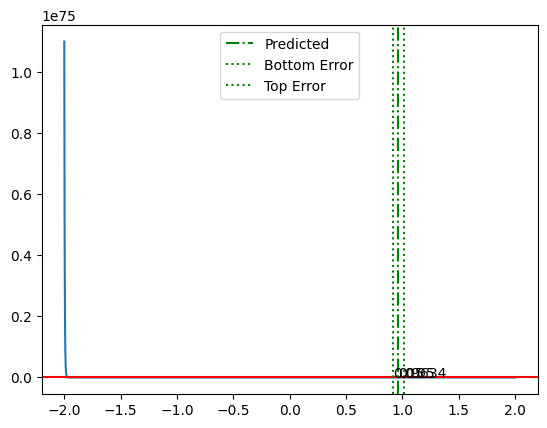

In [7]:
plt.plot(x,y) # plotting the values
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=P_Max, color='green',linestyle='-.', label="Predicted")
plt.axvline(x=P_Max - P_BT_Err, color='green',linestyle='dotted', label="Bottom Error")
plt.axvline(x=P_Max + P_UP_Err, color='green',linestyle='dotted', label="Top Error")
plt.annotate(np.round(P_Max,8), xy=(P_Max, rm), xytext=(P_Max,rm)) #drawing the horizontal values 
plt.annotate(np.round(P_BT_Err,4), xy=(P_Max - P_BT_Err, 1), xytext=(P_Max - P_BT_Err +0.005, 1.05),)
plt.annotate(np.round(P_UP_Err,4), xy=(P_Max + P_UP_Err, 1), xytext=(P_Max + P_UP_Err +0.005, 1.05),)
plt.legend()
print(P_Max)
print(P_UP_Err)

In [15]:
#EMCEE
def emcee1(a,o):
    s = 10 - np.log(Cosmo_Power(o[0],o[1],o[2],o[3],a[0],o[4])) #same funtion as above
    
    return (s)

In [9]:
ndim = 1 #Number Of Dimension
nwalkers = 70 #Number of Walkers
para = [0.0228,0.1208,67.29,0.0542,0.945,2.0969] #set basic parameters
import emcee #import Emcee
erty = [0.0228,0.1208,67.29,0.0542,2.0969]
sampler = emcee.EnsembleSampler(nwalkers, ndim, emcee1, args=[erty]) #ensampler

p_initial = [] #setting the initial values for the function to calulate
for l in np.arange(nwalkers):
    s = np.random.uniform(-2,2)
    p_initial.append([s])


In [10]:
state = sampler.run_mcmc(p_initial,100,progress = True) #running the sampler with p0 intitals
sampler.reset()

D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:383: RuntimeWarning: overflow encountered in power
  return 10.**self.predictions_np(parameters_dict)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
  0%|                                                                                          

In [11]:
sampler.run_mcmc(state, 1000,progress = True) #running the sampler for new samples

  0%|▎                                                                                                                    | 3/1000 [00:02<13:27,  1.23it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2
  6%|███████▎                                                                                                            | 63/1000 [00:39<09:08,  1.71it/s]C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:73: RuntimeWarning: overflow encountered in multiply
  CO = tt_spectra[0]*1e12 * 2.73**2. #K^2 to uK^2
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:91: RuntimeWarning: overflow encountered in multiply
  pred = Cosmo('TT',params)*dl_fac
 10%|███████████▌                                                                                                       | 100/1000 [01:02<09:19,  1.61it/s]C:\Users\E

State([[ 0.71213353]
 [ 0.58690081]
 [ 0.76777754]
 [ 0.81313131]
 [ 0.97446662]
 [ 0.15738405]
 [ 0.0851528 ]
 [ 0.67574836]
 [ 0.1125522 ]
 [ 1.00977701]
 [ 0.2367334 ]
 [ 0.43007007]
 [ 0.09322547]
 [ 0.47340752]
 [ 0.86037782]
 [ 1.10846555]
 [ 0.4635884 ]
 [ 0.35450718]
 [ 0.08097032]
 [ 0.53449795]
 [-0.1498355 ]
 [ 0.13569679]
 [ 0.39041215]
 [ 0.36745923]
 [ 0.8604905 ]
 [ 0.17334948]
 [ 0.69802349]
 [ 1.21802395]
 [ 0.37318188]
 [ 0.01740758]
 [ 0.28674476]
 [ 0.61234005]
 [ 0.20633762]
 [ 0.50187829]
 [ 0.87097556]
 [ 1.03746897]
 [-0.01461086]
 [ 0.81003836]
 [ 0.90134198]
 [ 0.11241176]
 [ 0.45864496]
 [-0.17455873]
 [ 0.13726611]
 [ 0.59878017]
 [-0.23886938]
 [ 0.28422908]
 [ 0.21141145]
 [ 0.26759908]
 [ 0.8516846 ]
 [ 0.95082722]
 [ 0.02274398]
 [ 0.29041876]
 [ 1.09411811]
 [ 0.06115756]
 [ 0.16904798]
 [ 0.62696669]
 [ 0.83347904]
 [ 0.44267335]
 [ 0.30131685]
 [ 0.47018287]
 [ 0.53295213]
 [-0.14691121]
 [ 0.72323851]
 [ 0.33780676]
 [ 0.25189147]
 [ 0.95133557]
 [ 0

In [12]:
flat_samples = sampler.get_chain(discard=100, flat=True) #flattening samples

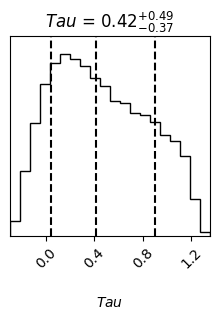

In [13]:
import corner
#plotting the samples
fig = corner.corner( 
    flat_samples,
    labels=[
        r"$Tau$", #add or change of names
    ],
    quantiles=[0.16,0.5,0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
);

In [14]:
from IPython.display import display, Math
labels = ["tau"] #finding the values for original and upper and lower error of the parameters with qual=ntile methode
for i in np.arange(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16,50,84])
    #print(np.quantile(flat_samples[:, i],[0.16,0.5,0.84]))
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(mcmc[1])
    display(Math(txt))

0.41738599322758557


<IPython.core.display.Math object>

In [12]:
print(np.shape(np.mean(flat_samples,axis=1)))

(45000,)


In [16]:
"""ref = 0.0228,0.1208,67.29,0.0542,0.945,2.0969 """
def cobaya_com(ns): #same Function cobaya
    return (10 - np.log(Cosmo_Power(0.0228,0.1208,67.29,0.0542,ns,2.0969)))

In [18]:
#COBAYA
# below is parameters for 6 parameter cosmopower
info = {"likelihood": {"cosmo1": cobaya_com}}
info["params"] = {
    "ns": {"prior": {"min": -4, "max": 2}, "proposal": 0.000001},
}
info["sampler"] = {"mcmc": {"Rminus1_stop": 0.0001, "max_tries": 1000}}
updated_info, sampler = run(info)

[cosmo1] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdfs for some parameters were not provided. Sampling from the prior instead for those parameters.
[mcmc] Initial point: ns:1.654153
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {cosmo1: 112.0}
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Sampling!
[mcmc] Progress @ 2024-11-18 22:31:59 : 1 steps taken, and 0 accepted.


D:\Python\project_cosmology\cospo\lib\site-packages\cosmopower\cosmopower_NN.py:336: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:92: RuntimeWarning: overflow encountered in multiply
  chi = chi2(Dl_TT*dl_fac,Dl_TT_err_up*dl_fac,Dl_TT_err_bot*dl_fac,pred*dl_fac)
C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.152813 after 32 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.


D:\Python\project_cosmology\cospo\lib\site-packages\cobaya\collection.py:651: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  self._data = pd.concat([


[mcmc] Learn + convergence test @ 80 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 6.295953 after 64 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 2.871225 after 96 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 160 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.209838 after 128 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 200 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 0.408775 after 160 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 240 samples accepted.
[mcmc]  - Acceptance rate: 1.000
[mcmc]  - Convergence of means: R-1 = 1.176825 after 192 a

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 3160 samples accepted.
[mcmc]  - Acceptance rate: 0.338
[mcmc]  - Convergence of means: R-1 = 0.000875 after 2528 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3200 samples accepted.
[mcmc]  - Acceptance rate: 0.337
[mcmc]  - Convergence of means: R-1 = 0.000911 after 2560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3240 samples accepted.
[mcmc]  - Acceptance rate: 0.338
[mcmc]  - Convergence of means: R-1 = 0.001585 after 2592 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3280 samples accepted.
[mcmc]  - Acceptance rate: 0.339
[mcmc]  - Convergence of means: R-1 = 0.000324 after 2624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 3320 samples accepted.
[mcmc]  - Acceptance rate: 0.339
[mcmc]  - Convergence of means: R-1 = 0.000687

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 9560 samples accepted.
[mcmc]  - Acceptance rate: 0.344
[mcmc]  - Convergence of means: R-1 = 0.000345 after 7648 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9600 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.000592 after 7680 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9640 samples accepted.
[mcmc]  - Acceptance rate: 0.344
[mcmc]  - Convergence of means: R-1 = 0.000516 after 7712 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9680 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.000836 after 7744 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 9720 samples accepted.
[mcmc]  - Acceptance rate: 0.344
[mcmc]  - Convergence of means: R-1 = 0.000693

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 10520 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.000765 after 8416 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10560 samples accepted.
[mcmc]  - Acceptance rate: 0.342
[mcmc]  - Convergence of means: R-1 = 0.000836 after 8448 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10600 samples accepted.
[mcmc]  - Acceptance rate: 0.342
[mcmc]  - Convergence of means: R-1 = 0.000779 after 8480 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10640 samples accepted.
[mcmc]  - Acceptance rate: 0.342
[mcmc]  - Convergence of means: R-1 = 0.000772 after 8512 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 10680 samples accepted.
[mcmc]  - Acceptance rate: 0.342
[mcmc]  - Convergence of means: R-1 = 0.0

C:\Users\ELAKIA\AppData\Local\Temp\ipykernel_30288\1817034102.py:35: RuntimeWarning: overflow encountered in square
  c = ((tre - pred)**2)/((teu + trb)**2) # (Real - Model)^2/(Error Up + Error Bottom)^2


[mcmc] Learn + convergence test @ 13200 samples accepted.
[mcmc]  - Acceptance rate: 0.344
[mcmc]  - Convergence of means: R-1 = 0.000728 after 10560 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13240 samples accepted.
[mcmc]  - Acceptance rate: 0.344
[mcmc]  - Convergence of means: R-1 = 0.000499 after 10592 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13280 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.000588 after 10624 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13320 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 = 0.000517 after 10656 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 13360 samples accepted.
[mcmc]  - Acceptance rate: 0.343
[mcmc]  - Convergence of means: R-1 =

[mcmc] *WARNING* When combining chains, it is recommended to remove some initial fraction, e.g. 'skip_samples=0.3'
(14360,)


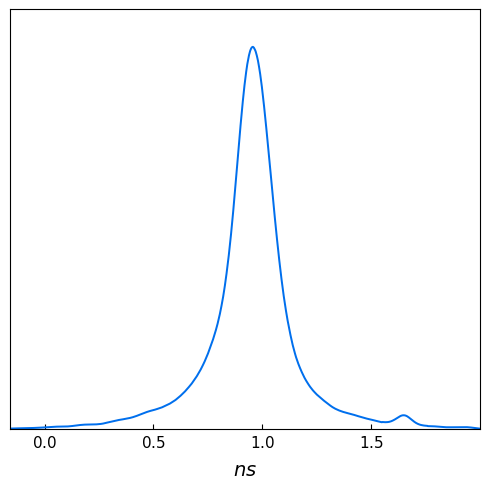

In [20]:
%matplotlib inline
import getdist.plots as gdplt
#Plotting the values
gdsamples = sampler.products(to_getdist=True)["sample"]
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(gdsamples, ["ns"], filled=True)
print(np.shape(gdsamples[2]))

In [21]:
p = ["omb","omc","h","tau","ns","AS"]
s = gdsamples.samples[np.argmin(gdsamples.loglikes)]
for i in np.arange(1):
    print("For the parameter ",p[i]," The acquired value is",s[i])

x = [] #deconstructing the samples for calculating without 
y = []

for i in np.arange(np.shape(gdsamples[0])[0]):
    x.append(gdsamples[0][i])
    y.append(gdsamples[1][i])


x1 = np.sort(x)
x2 = []
for i in x1:
    x2.append(i)
y1 = []
yc = []
ymax = 0 
for i in x2:
    rpos  = x.index(i)
    y4 = -y[rpos]
    y1.append(y4)
    if y4 < 1:
        None
    else:
        yc.append([i,y4])
        if ymax < y4:
            ymax = y4
        else:
            None
Ps_Max = x2[np.where(y1 == ymax)[0][0]]
Ps_UP = yc[-1][0] - Ps_Max 
Ps_BT = Ps_Max - yc[0][0] 
print(Ps_UP)

For the parameter  omb  The acquired value is 0.9633782678066565
0.3831822057399381


In [89]:
rm

1500

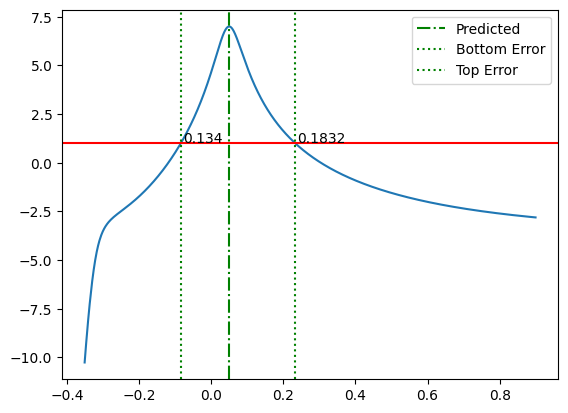

In [87]:
plt.plot(x2,y1)
plt.axhline(y=1, color='r', linestyle='-')
plt.axvline(x=Ps_Max, color='green',linestyle='-.', label="Predicted")
plt.axvline(x=Ps_Max - Ps_BT, color='green',linestyle='dotted', label="Bottom Error")
plt.axvline(x=Ps_Max + Ps_UP, color='green',linestyle='dotted', label="Top Error")
plt.annotate(np.round(Ps_Max,4), xy=(Ps_Max, rm), xytext=(Ps_Max,ymax))
plt.annotate(np.round(Ps_BT,4), xy=(Ps_Max - Ps_BT, 1), xytext=(Ps_Max - Ps_BT +0.005, 1.05),)
plt.annotate(np.round(Ps_UP,4), xy=(Ps_Max + Ps_UP, 1), xytext=(Ps_Max + Ps_UP +0.005, 1.05),)
plt.legend()